# Master's Thesis Experiments Report

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scripts.utils import load_latency_data, load_packet_data, clean_latency_data

In [2]:
# constants
LAST_FRAME = 526
FIG_DIR = './figures/{}'

## 1.   Pipeline Latency
The data was replayed at 8 Mbps.
For each frame f, we measure the timedelta between the last emitted LiDAR data packet and
the last incoming Palicus data packet containing data associated with f.
We exclude the first and the last frame to ensure that we only consider the latency of full frames.

In [3]:
fig_dir = FIG_DIR.format('latency')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [6]:
# Load the data
df_conversion = load_latency_data(max_frame=LAST_FRAME - 1)
df_roi = load_latency_data(pipeline='roi', max_frame=LAST_FRAME - 1)
df_dm1 = load_latency_data(pipeline='dm1', max_frame=LAST_FRAME - 1)
df_dm2 = load_latency_data(pipeline='dm2', max_frame=LAST_FRAME - 1)
df_bev = load_latency_data(pipeline='bev', max_frame=LAST_FRAME - 1)
df_max = load_latency_data(pipeline='max', max_frame=LAST_FRAME - 1)

In [7]:
# tabular representation
l = 'latency [ms]'
# only consider frames if their latency is within (mean - 2*sd, mean + 2 * sd)
df_conv_clean = clean_latency_data(df_conversion)
df_roi_clean = clean_latency_data(df_roi)
df_dm1_clean = clean_latency_data(df_dm1)
df_dm2_clean = clean_latency_data(df_dm2)
df_bev_clean = clean_latency_data(df_bev)
df_max_clean = clean_latency_data(df_max)

results = [['min', df_conv_clean.min()[l], df_roi_clean.min()[l], df_dm1_clean.min()[l], df_dm2_clean.min()[l], df_bev_clean.min()[l], df_max_clean.min()[l]],
           ['mean', df_conv_clean.mean()[l], df_roi_clean.mean()[l], df_dm1_clean.mean()[l], df_dm2_clean.mean()[l], df_bev_clean.mean()[l], df_max_clean.mean()[l]],
           ['median', df_conv_clean.median()[l], df_roi_clean.median()[l], df_dm1_clean.median()[l], df_dm2_clean.median()[l], df_bev_clean.median()[l], df_max_clean.median()[l]],
           ['max', df_conv_clean.max()[l], df_roi_clean.max()[l], df_dm1_clean.max()[l], df_dm2_clean.max()[l], df_bev_clean.max()[l], df_max_clean.max()[l]]
           ]

df_latency_results = pd.DataFrame(np.array(results), columns=['', 'CONV', 'RoI', 'DM (1)', 'DM (2)', 'BEV', 'MAX'])
print(df_latency_results)



                         CONV                 RoI               DM (1)  \
0     min                0.18               0.174                0.178   
1    mean  0.2960838445807771  0.2920987654320988  0.29519753086419753   
2  median               0.293               0.292                0.299   
3     max               0.577               0.529                0.515   

               DM (2)                BEV                MAX  
0               0.176             46.422            141.214  
1  0.3010329218106995  47.39483725490196  234.0225118790497  
2              0.3045             47.702            234.813  
3               0.513             48.073            236.362  


### Filter and Arithmetic Processing Elements

C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\3051513321.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_conversion['latency [ms]'].to_numpy(), positions=[2], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\3051513321.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_roi['latency [ms]'].to_numpy(), positions=[4], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\3051513321.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_dm1['latency [ms]'].to_numpy(), positions=[6], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\3051513321

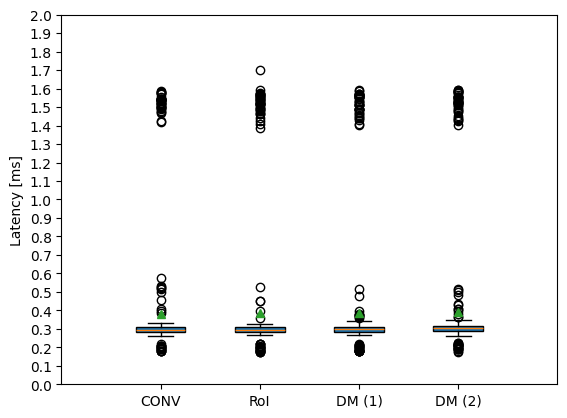

In [9]:
# computation time: conversion vs. RoI vs. DepthMap
fig, ax = plt.subplots()
ax.boxplot(df_conversion['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=True, showfliers=True, labels=['CONV'])
ax.boxplot(df_roi['latency [ms]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=True, showfliers=True, labels=['RoI'])
ax.boxplot(df_dm1['latency [ms]'].to_numpy(), positions=[6], widths=[1],
           patch_artist=True, showmeans=True, showfliers=True, labels=['DM (1)'])
ax.boxplot(df_dm2['latency [ms]'].to_numpy(), positions=[8], widths=[1],
           patch_artist=True, showmeans=True, showfliers=True, labels=['DM (2)'])
ax.set(xlim=(0, 10))
ax.set(ylim=(0, 2), yticks=[i / 10 for i in range(21)], ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'conv_roi_dm.png'))

C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\2135672299.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_conversion['latency [us]'].to_numpy(), positions=[2], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\2135672299.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_roi['latency [us]'].to_numpy(), positions=[4], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\2135672299.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_dm1['latency [us]'].to_numpy(), positions=[6], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\21356722

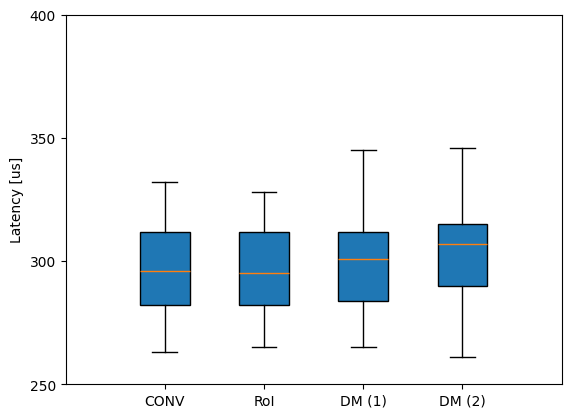

In [10]:
# computation time: conversion vs. RoI vs. DepthMap
df_conversion['latency [us]'] = df_conversion['latency [ms]'] * 1000
df_roi['latency [us]'] = df_roi['latency [ms]'] * 1000
df_dm1['latency [us]'] = df_dm1['latency [ms]'] * 1000
df_dm2['latency [us]'] = df_dm2['latency [ms]'] * 1000


fig, ax = plt.subplots()
ax.boxplot(df_conversion['latency [us]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['CONV'])
ax.boxplot(df_roi['latency [us]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['RoI'])
ax.boxplot(df_dm1['latency [us]'].to_numpy(), positions=[6], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (1)'])
ax.boxplot(df_dm2['latency [us]'].to_numpy(), positions=[8], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (2)'])
ax.set(xlim=(0, 10))
ax.set(ylim=(250, 400), yticks=[250 + i * 50 for i in range(4)], ylabel='Latency [us]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'conv_roi_dm_no_outliers.png'))

### Aggregation Processing Element

C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\1291938689.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],
C:\Users\sophi\AppData\Local\Temp\ipykernel_18200\1291938689.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(df_max['latency [ms]'].to_numpy(), positions=[4], widths=[1],


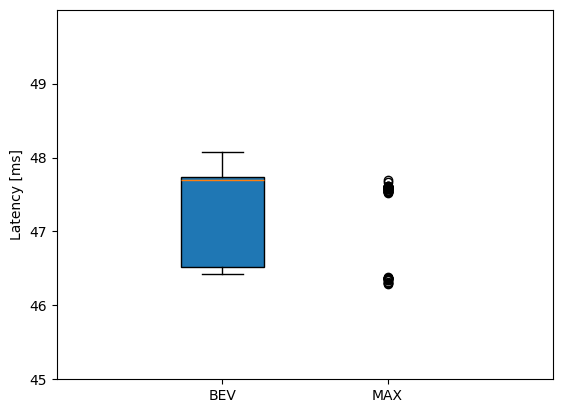

In [11]:
# computation time: BEV vs. MAX
fig, ax = plt.subplots()
ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, labels=['BEV'])
ax.boxplot(df_max['latency [ms]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=True, labels=['MAX'])
ax.set(xlim=(0, 6))
ax.set(ylim=(45, 50), yticks=[45 + i for i in range(5)], ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'bev_max.png'))

## 2. Point Rate

In [65]:
# Conversion
total_pkt = []
for p in ['conversion', 'roi', 'dm1', 'dm2', 'bev', 'max']:
    log = [p]
    for t in ['8Mbps', '128Mbps']:
        df = load_packet_data(throughput=t, pipeline=p, max_frame=LAST_FRAME-1)
        packet_count = len(df)
        log.append(packet_count)
    total_pkt.append(log)

df_res = pd.DataFrame(np.array(total_pkt), columns=['pipeline', '8Mbps', '128Mbps'])
df_res['difference'] = df_res.apply(lambda row: int(row['8Mbps']) - int(row['128Mbps']), axis=1)

print(df_res.head(10))

     pipeline   8Mbps 128Mbps  difference
0  conversion  237612  237615          -3
1         roi  227063  227045          18
2         dm1  227063  226994          69
3         dm2  227063  227018          45
4         bev    1558    1557           1
5         max    1558    1558           0
